# How it works

To convert Python code into a quantum circuit, qlasskit implements a series of transformations:

1. It begins with the Python *AST* (Abstract Syntax Tree), converting it into a more streamlined form using the `ast2ast` module. 
2. Next, the streamlined AST is translated into *boolean expressions* as an intermediate step by the `ast2logic` module. 
During this phase, boolean expressions are refined and optimized in preparation for the final transformation.
3. Finally, the `compiler` module takes these optimized boolean expressions and compiles them into a 
*quantum circuit*.

Unlike other libraries that translate individual operations into quantum circuits before combining them, 
qlasskit constructs a singular boolean expression for each output qubit of the entire function. 
This unique approach facilitates advanced optimization leveraging boolean algebraic properties.


For instance, let assume we have the following function:


In [10]:
from qlasskit import qlassf, Qint2, Qint4
from qiskit import QuantumCircuit

@qlassf
def f_comp(b: bool, n: Qint2) -> Qint2:
      for i in range(3):
            n += (1 if b else 2)
      return n

If we decompose the algorithm in 3 separate additions and we compile them separately, we obtain the following circuit:

Operations: OrderedDict([('cx', 12), ('barrier', 3), ('ccx', 3), ('x', 3)])


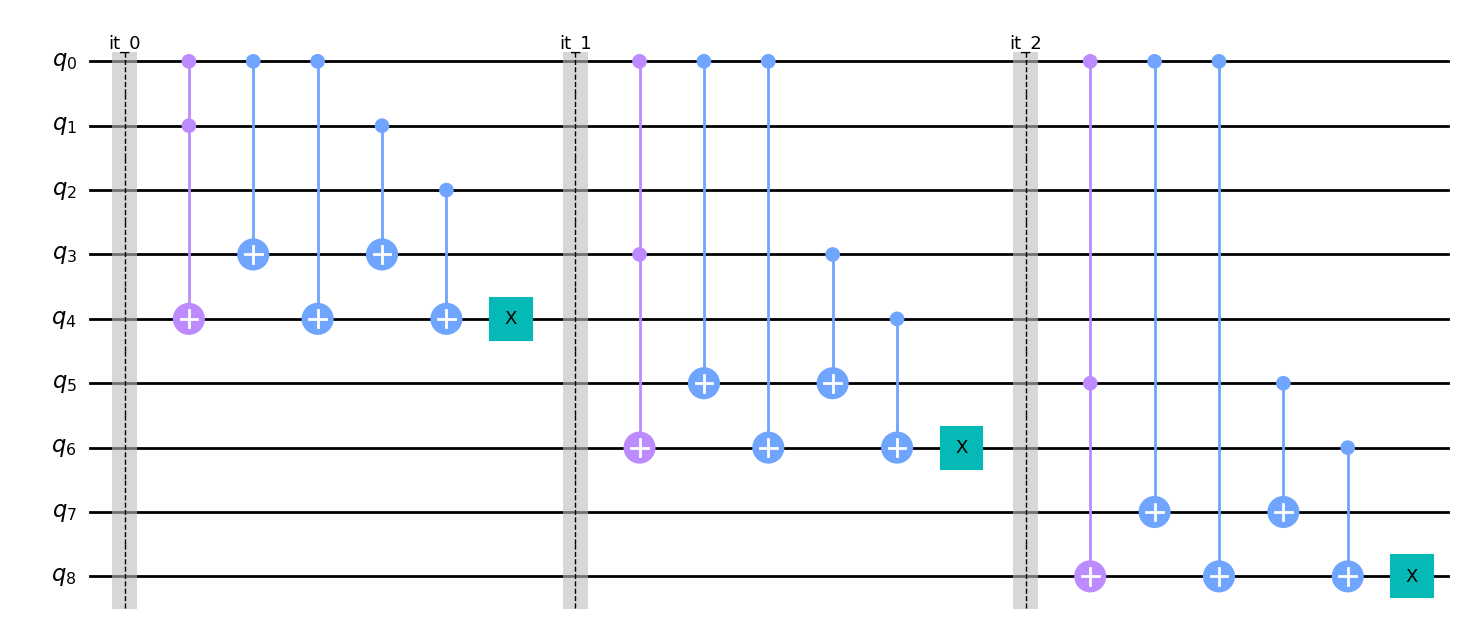

In [21]:
@qlassf
def f1(b: bool, n: Qint2) -> Qint2:
    return n + (1 if b else 2)

f1.compile("tweedledum")
qc = QuantumCircuit(f_comp.num_qubits * 2 - 1)

for i in range(3):
    qc.barrier(label=f"it_{i}")
    qc.append(f1.gate(), [0] + list(range(1 + i * 2, 5 + i * 2)))

print('Operations:', qc.decompose().count_ops())
qc.decompose().draw("mpl")

While if we compile the whole function to a quantum circuit using qlasskit, we obtain the following quantum circuit:

Operations: OrderedDict([('cx', 4), ('x', 1), ('ccx', 1)])


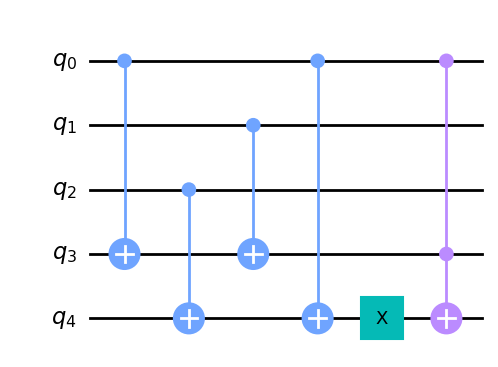

In [12]:
qc = QuantumCircuit(f_comp.num_qubits)
qc.append(f_comp.gate(), f_comp.qubits)

print('Operations:', qc.decompose().count_ops())
qc.decompose().draw("mpl")

As we can see from the circuit drawings, qlasskit approach needs half the number of qubits and half the number of gates.

## AST Traslator
Given a python function, the `qlasskit.ast2logic` module walks its syntax tree translating all the statements / 
expressions to boolean expressions.


For instance, the following function:

In [13]:
@qlassf
def f(n: Qint4) -> bool:
        return n == 3       

Is translated to this boolean expression:

In [15]:
print(f.expressions)

[(_ret, n.0 & n.1 & ~n.2 & ~n.3)]



## Compiler

The boolean expressions are then being fed to the `qlasskit.compiler`` which compiles boolean expressions
to invertible circuits, introducing auxiliary qubits. In this step, the compiler will automatically uncompute 
auxiliary qubits in order to reduce the number of qubits needed and the circuit footprint. 

For the compilation, two backends are supported:

- InternalCompiler
- Tweedledum.xag_synth


## Result 

The result of the compiler is a quantum circuit represented with qlasskit `QCircuit`. This circuit
can now be exported to one of the supported framework as a gate or as a standalone circuit.


The previous example function `f`, is translated to the following quantum circuit: the 
result is available at qubit `q6`.

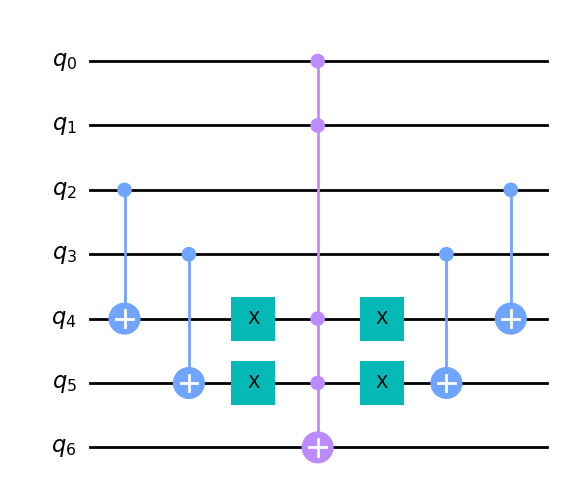

In [19]:
f.export().draw('mpl')